<a href="https://colab.research.google.com/github/jeanf009/Knowledge-Graph-NLP/blob/main/GrafoConhecimentoPLN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 54.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


<ipython-input-1-f6d0e78c7536>:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


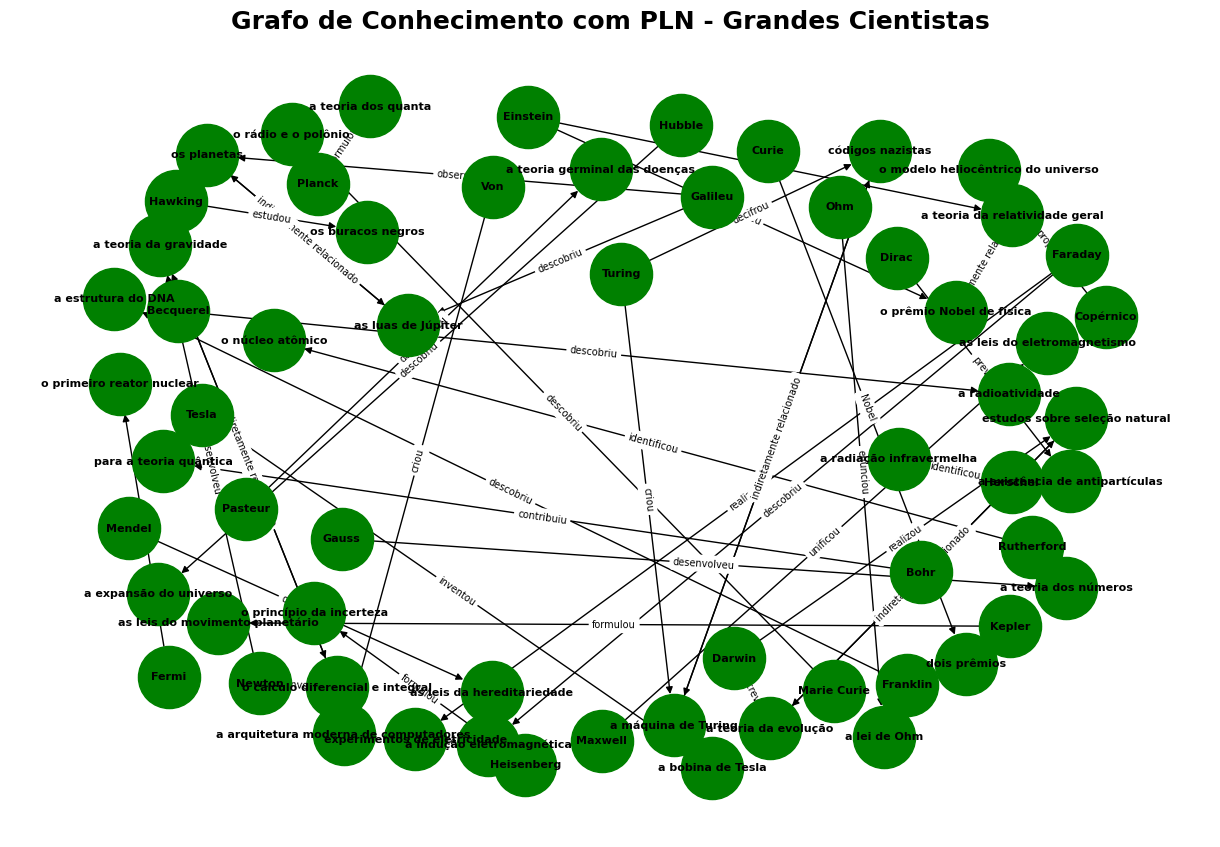

         source                                 target         edge
0      Einstein               o prêmio Nobel de física      recebeu
1        Newton                  a teoria da gravidade  desenvolveu
2       Galileu                            os planetas     observou
3        Kepler        as leis do movimento planetário     formulou
4       Galileu                     as luas de Júpiter    descobriu
5        Darwin                   a teoria da evolução     escreveu
6       Pasteur          a teoria germinal das doenças  desenvolveu
7         Tesla                      a bobina de Tesla     inventou
8   Marie Curie                    o rádio e o polônio    descobriu
9       Faraday           experimentos de eletricidade     realizou
10         Bohr                 para a teoria quântica   contribuiu
11      Hawking                      os buracos negros      estudou
12       Turing                    a máquina de Turing        criou
13    Copérnico     o modelo heliocêntrico do un

<ipython-input-1-f6d0e78c7536>:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


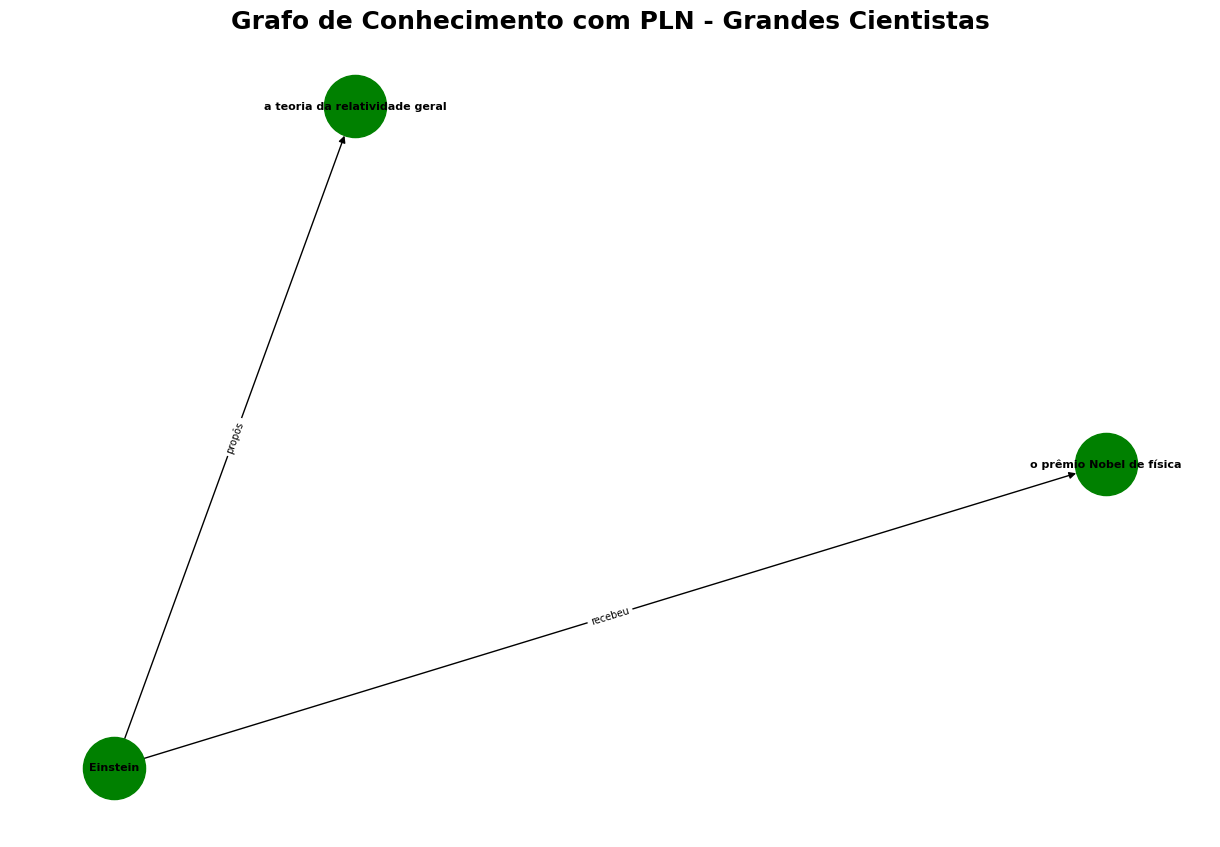

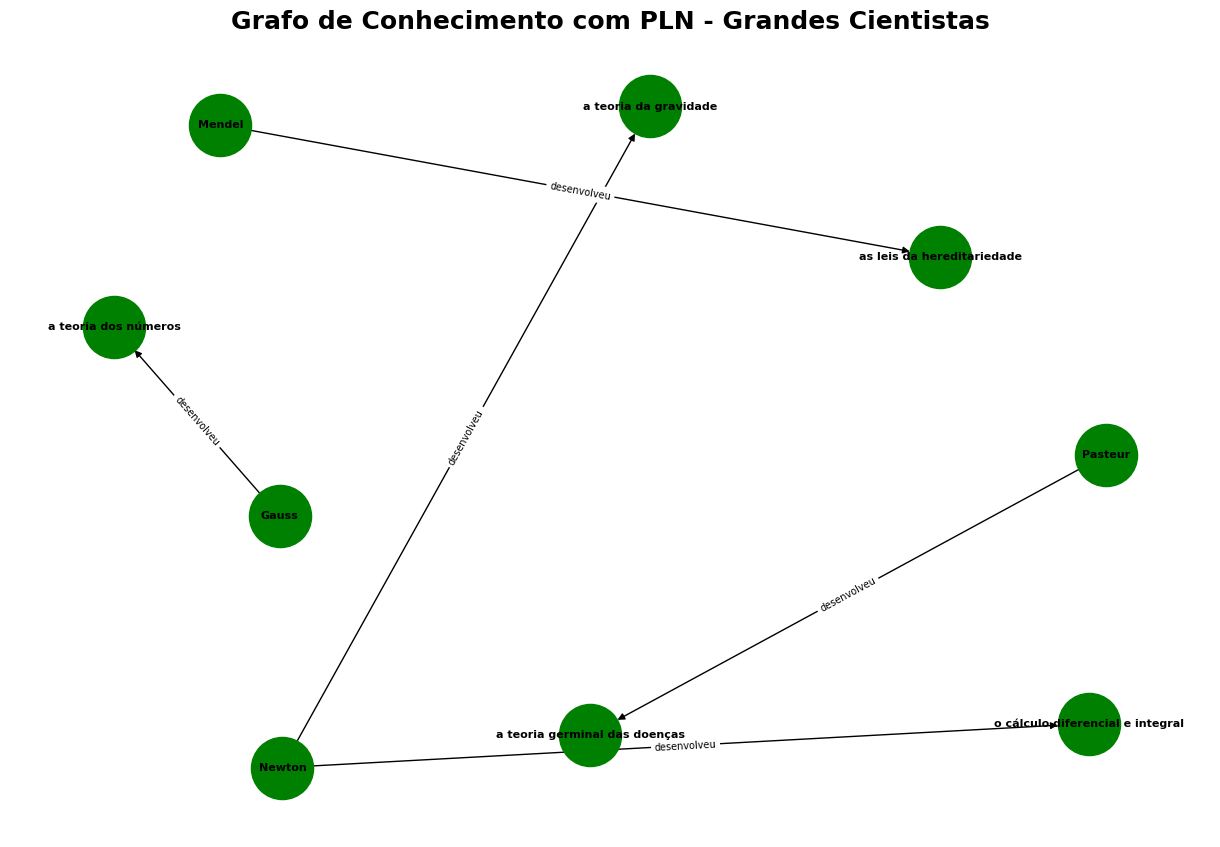

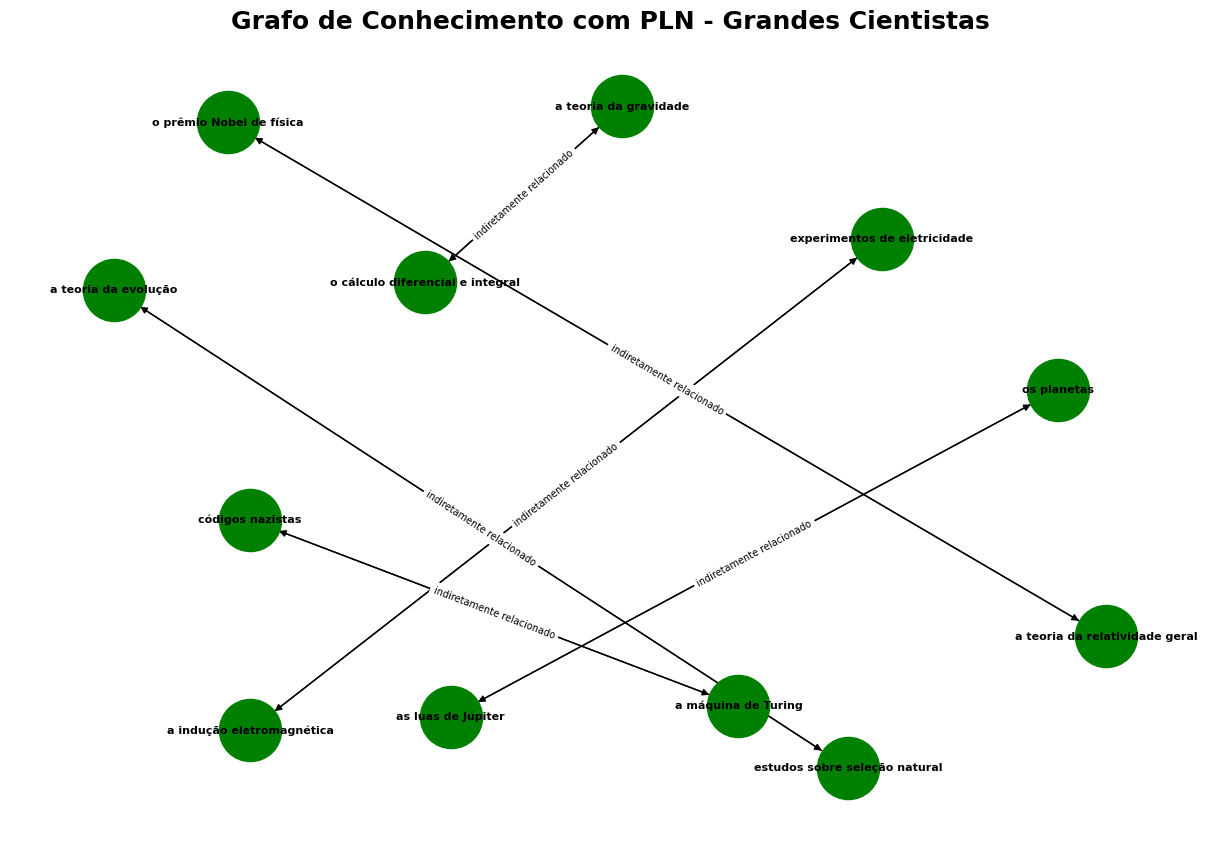

In [ ]:
!pip install spacy networkx matplotlib
!python -m spacy download pt_core_news_sm

import spacy
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from spacy.matcher import Matcher


nlp = spacy.load("pt_core_news_sm")

G = nx.DiGraph()

def load_sentences(file_path):

    with open(file_path, 'r', encoding='utf-8') as file:
        sentences = file.readlines()

    return [sentence.strip() for sentence in sentences if sentence.strip()]

file_path = "/content/cientistas.txt"

sentences = load_sentences(file_path)

# métodos de manipulação do grafo
def add_node(G, node):

  if not G.has_node(node):
        G.add_node(node)
        print(f"O nó {node} foi inserido com sucesso no grafo.")


def add_edge(G, source, target, edge_label):

    if not G.has_edge(source, target):
        G.add_edge(source, target, label=edge_label)
        print(f"Aresta '{source} direcionada a '{target}' com o rótulo '{edge_label}' foi inserida com sucesso no grafo.")

def remove_node(G, node):

    if G.has_node(node):
        G.remove_node(node)
        print(f"O nó '{node}' foi removido com sucesso do grafo.")

def remove_edge(G, source, target):

    if G.has_edge(source, target):
        G.remove_edge(source, target)
        print(f"A aresta '{source}' direcionada a '{target}' foi removida com sucesso do grafo.")


# método de visualização do grafo de conhecimento a partir do MatPlotLib/NetworkX
def display_knowledge_graph(G):

    pos = nx.spring_layout(G, seed=42, k=2.0, iterations=10)
    plt.figure(figsize=(12, 8))

    nx.draw(G, pos, with_labels=True, node_color="green", node_size=2000, font_size=8, font_color="black", font_weight="bold", arrows=True)
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7, label_pos=0.5)

    plt.title("Grafo de Conhecimento com PLN - Grandes Cientistas", fontsize=18, fontweight="bold")

    plt.tight_layout()
    plt.axis('off')
    plt.show()


def get_entities_and_relations(sent): # PLN em ação

  # sujeito, objeto e relação (verbo), respectivamente:

    entity1 = ""
    entity2 = ""
    relation = ""

    document = nlp(sent)

    for token in document:

        if token.dep_ != "punct":

            if token.dep_.find("subj") != -1:
                entity1 = " ".join([w.text for w in token.subtree])


            if token.dep_.find("obj") != -1:
                entity2 = " ".join([w.text for w in token.subtree])

            if token.dep_ == "ROOT":
                relation = token.text

    return [entity1.strip(), entity2.strip(), relation.strip()]


# armazenar informações de entidades e relações
entity_pairs = []
relations = []

entity_map = {}

# conectando o grafo de conhecimento
for sent in sentences:

    entity1, entity2, relation = get_entities_and_relations(sent)

    if entity1 and entity2 and relation:

        G.add_node(entity1)
        G.add_node(entity2)
        G.add_edge(entity1, entity2, label=relation)

       # atualizando o mapa de entidades
        if entity1 not in entity_map:
            entity_map[entity1] = set()

        if entity2 not in entity_map:
            entity_map[entity2] = set()

        entity_map[entity1].add(entity2)
        entity_map[entity2].add(entity1)

        # construindo a "planilha" (dataFrame) p/ visualizar como a NLP interpretou e classificou cada token
        entity_pairs.append([entity1, entity2])
        relations.append(relation)

#  relações indiretas. ex: "Newton desenvolveu a teoria da gravidade e o cálculo", então ambas invenções estarão conectadas também
for entity, related_entities in entity_map.items():

    for related in related_entities:

        if related in entity_map:

            for second_related in entity_map[related]:

                if second_related != entity and not G.has_edge(entity, second_related):

                    if second_related in entity_map and entity in entity_map:
                        G.add_edge(entity, second_related, label="indiretamente relacionado")


display_knowledge_graph(G)


triple_visualization = pd.DataFrame({'source': [i[0] for i in entity_pairs], 'target': [i[1] for i in entity_pairs], 'edge': relations})
print(triple_visualization)


def filter_entity(G, entity): # filtro por entidade (nome do cientista)

    if entity in G:

        subgraph_edges = []

        for neighbor in G.neighbors(entity):
            subgraph_edges.append((entity, neighbor))

        subgraph = G.edge_subgraph(subgraph_edges)

    display_knowledge_graph(subgraph)


def filter_relation(G, relation): # filtro por relação (feito do cientista)

  subgraph_edges = [(inicial_node, destine_node) for inicial_node, destine_node, edge_dict in G.edges(data=True) if edge_dict['label'] == relation]
  subgraph = G.edge_subgraph(subgraph_edges)

  display_knowledge_graph(subgraph)

filter_entity(G, "Einstein")
filter_relation(G, "desenvolveu")
filter_relation(G, "indiretamente relacionado")

